# Likelihood Ratio Processes and Bayesian Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import vectorize, njit
from math import gamma
%matplotlib inline

In [2]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# The two density functions.
f = njit(lambda x: p(x, F_a, F_b))
g = njit(lambda x: p(x, G_a, G_b))

In [3]:
@njit
def simulate(a, b, T=50, N=500):
    '''
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix.

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

In [4]:
l_arr_g = simulate(G_a, G_b, N=50000)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [5]:
l_arr_f = simulate(F_a, F_b, N=50000)
l_seq_f = np.cumprod(l_arr_f, axis=1)

In [6]:
@njit
def update(π, l):
    "Update π using likelihood l"

    # Update belief
    π = π * l / (π * l + 1 - π)

    return π

In [7]:
π1, π2 = 0.2, 0.8

In [8]:
T = l_arr_f.shape[1]
π_seq_f = np.empty((2, T+1))
π_seq_f[:, 0] = π1, π2

for t in range(T):
    for i in range(2):
        π_seq_f[i, t+1] = update(π_seq_f[i, t], l_arr_f[0, t])

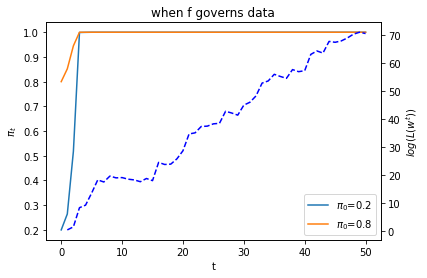

In [9]:
fig, ax1 = plt.subplots()

for i in range(2):
    ax1.plot(range(T+1), π_seq_f[i, :], label=f"$\pi_0$={π_seq_f[i, 0]}")

ax1.set_ylabel("$\pi_t$")
ax1.set_xlabel("t")
ax1.legend()
ax1.set_title("when f governs data")

ax2 = ax1.twinx()
ax2.plot(range(1, T+1), np.log(l_seq_f[0, :]), '--', color='b')
ax2.set_ylabel("$log(L(w^{t}))$")

plt.show()

In [10]:
T = l_arr_g.shape[1]
π_seq_g = np.empty((2, T+1))
π_seq_g[:, 0] = π1, π2

for t in range(T):
    for i in range(2):
        π_seq_g[i, t+1] = update(π_seq_g[i, t], l_arr_g[0, t])

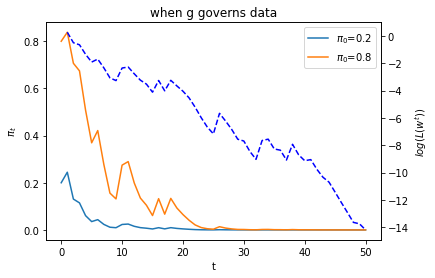

In [11]:
fig, ax1 = plt.subplots()

for i in range(2):
    ax1.plot(range(T+1), π_seq_g[i, :], label=f"$\pi_0$={π_seq_g[i, 0]}")

ax1.set_ylabel("$\pi_t$")
ax1.set_xlabel("t")
ax1.legend()
ax1.set_title("when g governs data")

ax2 = ax1.twinx()
ax2.plot(range(1, T+1), np.log(l_seq_g[0, :]), '--', color='b')
ax2.set_ylabel("$log(L(w^{t}))$")

plt.show()

In [12]:
π_seq = np.empty((2, T+1))
π_seq[:, 0] = π1, π2

for i in range(2):
    πL = π_seq[i, 0] * l_seq_f[0, :]
    π_seq[i, 1:] = πL / (πL + 1 - π_seq[i, 0])

In [13]:
np.abs(π_seq - π_seq_f).max() < 1e-10

True